# Celestial Exploration: Unveiling the Secrets of the Cosmos
*Author: Mobina Jamali*

**This project is a data-driven exploration of the cosmos through analyzing the SDSS large-scale astronomical survey to explore and classify celestial objects based on their properties. By utilizing data mining techniques, training and tunning different models, the project aims to contribute to our understanding of celestial phenomena and provide valuable insights for future astronomical research.**  


**For the classification of celestial objects, I deployed three distinct machine learning models: k-Nearest Neighbors (KNN), Random Forest, and a Neural Network (MLP Classifier). Each model underwent meticulous fine-tuning, incorporating various regularization techniques and hyperparameter selections to maximize accuracy and dependability. The ensuing sections will provide a detailed exposition of the feature selection process, model training, hyperparameter tuning, and a comparative analysis of the obtained results.**

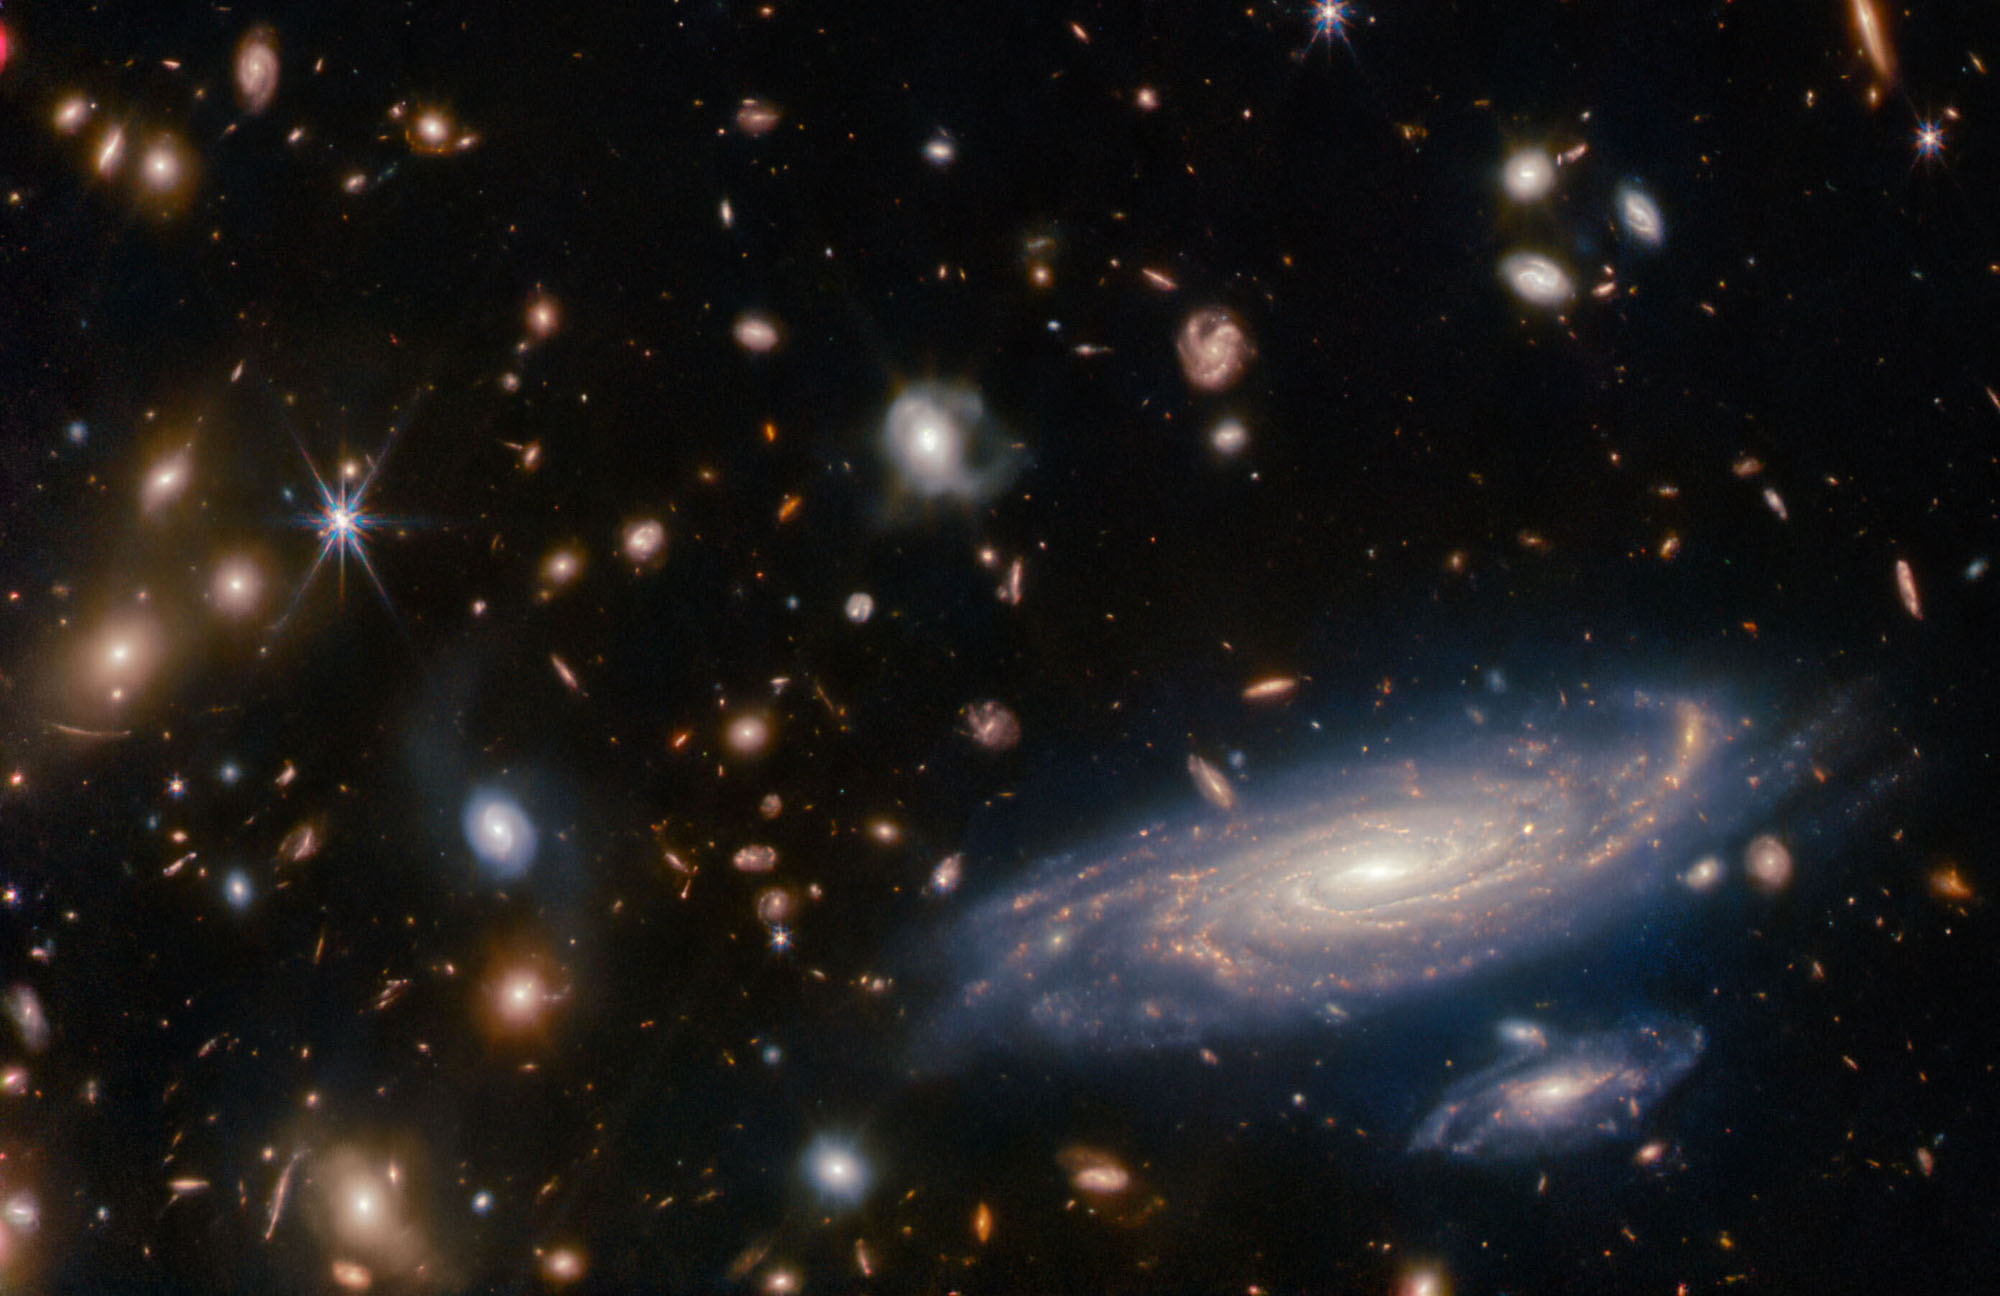

### SciServer:
**To facilitate the analysis, I performed all my work on SciServer platform. SciServer is a comprehensive cloud-based computing system that offers an extensive range of interconnected tools and services, empowering researchers to work with Terabytes or Petabytes of scientific data without needing to download any large datasets.**

https://apps.sciserver.org/dashboard/

### SDSS:
**Sloan Digital Sky Survey (SDSS) is a groundbreaking astronomical survey that employs a 2.5 meter telescope located at Apache Point Observatory in New Mexico, USA, and is equipped with a range of specialized instruments to capture detailed images and spectra of celestial objects. Its primary goals include mapping the structure of the universe, understanding the distribution of galaxies, and studying the properties of various celestial objects, including stars, galaxies, and quasars.**  

https://www.sdss.org/  

## Importing libraries:

In [2]:
import SciServer.CasJobs as CasJobs
import SciServer.SkyServer as SkyServer
import SciServer.SciDrive

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##  Querying the SDSS's database (DR16):

In [32]:
# Find objects in the SDSS's Data Release 16
query="""
SELECT TOP 10000 p.objId,p.ra,p.dec,p.u,p.g,p.r,p.i,p.z, p.petror90_r,
s.specobjid, s.class, s.z as redshift, s.plate, s.mjd, s.fiberid
FROM PhotoObj AS p
JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.u BETWEEN 0 AND 19.6
  AND p.g BETWEEN 0 AND 20  AND p.petror90_r > 10
"""
# Execute the SQL query using CasJobs and set the 'objId' column as the index
SDSS = CasJobs.executeQuery(query, "dr16")
SDSS = SDSS.set_index('objId')
SDSS.head()


ra       dec         u         g         r  \
objId                                                                     
1237648705132495223  225.801425  0.468648  18.43803  17.08073  16.50616   
1237648705132625938  225.984282  0.429600  17.37293  16.67231  16.44412   
1237648705132691481  226.167571  0.604518  17.60564  15.68840  14.79852   
1237648705133347051  227.671893  0.444198  18.17485  16.16745  15.19847   
1237648705133347074  227.674527  0.461569  18.33101  16.86031  16.08617   

                            i         z  petror90_r           specobjid  \
objId                                                                     
1237648705132495223  16.17469  15.96114    11.36842  349158472002070528   
1237648705132625938  16.50912  16.48517    17.00946  349162870048581632   
1237648705132691481  14.34542  14.01396    11.28164  349163694682302464   
1237648705133347051  14.75660  14.40484    13.94584  350281892555155456   
1237648705133347074  15.68345  15.38158    10.25939  350285740845852672   

                      class  redshift  plate    mjd  fiberid  
objId                                                         
1237648705132495223  GALAXY  0.040645    310  51990      471  
1237648705132625938  GALAXY  0.005270    310  51990      487  
1237648705132691481  GALAXY  0.040173    310  51990      490  
1237648705133347051  GALAXY  0.072524    311  51665      462  
1237648705133347074  GALAXY  0.072542    311  51665      476

The data consists of 100,000 observations of space taken by the SDSS. Every observation is described by 13 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar.

- *obj_ID* = Object Identifier, the unique value that identifies the object  
- *ra* = Right Ascension angle (at J2000 epoch)  
- *dec* = Declination angle (at J2000 epoch)  
- *u* = Ultraviolet filter in the photometric system  
- *g* = Green filter in the photometric system  
- *r* = Red filter in the photometric system  
- *i* = Near Infrared filter in the photometric system  
- *z* = Infrared filter in the photometric system  
- *spec_objID* = Unique ID used for optical spectroscopic objects 
- *class* = object class (galaxy, star or quasar object)  
- *redshift* = redshift value based on the increase in wavelength  
- *plate* = plate ID, identifies each plate in SDSS  
- *mjd* = Modified Julian Date, used to indicate when a given piece of SDSS data was taken  
- *fiberid* = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation  

In [60]:
SDSS.shape

(10000, 14)

### Data Exploration:

In [35]:
# Check for Missing Values
SDSS.isnull().any()

ra            False
dec           False
u             False
g             False
r             False
i             False
z             False
petror90_r    False
specobjid     False
class         False
redshift      False
plate         False
mjd           False
fiberid       False
dtype: bool

In [36]:
SDSS.describe()

ra           dec             u             g             r  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean     170.330528     20.534251     17.939597     16.353841     15.614860   
std       75.146432     26.330659      0.968505      0.948457      0.995347   
min        0.049664    -11.210584     11.726470     12.140080     11.234510   
25%      134.390531      0.254746     17.377485     15.797472     15.022735   
50%      173.151859      4.013144     18.039535     16.418980     15.639390   
75%      218.263187     49.596662     18.634493     17.020940     16.251335   
max      359.904204     68.725056     19.599700     19.976130     19.843320   

                  i             z    petror90_r     specobjid      redshift  \
count  10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean      15.249788     14.988203     14.750538  9.658777e+17      0.060799   
std        1.047502      1.145314      7.837691  1.328841e+18      0.152559   
min       10.713360     10.296110     10.001680  2.994949e+17     -0.004021   
25%       14.630535     14.326400     10.958928  4.887804e+17      0.028641   
50%       15.247910     14.941505     12.503975  6.035598e+17      0.046291   
75%       15.873063     15.606162     15.465658  7.420148e+17      0.074056   
max       22.745040     28.234510    160.047400  9.336203e+18      6.701415   

              plate           mjd       fiberid  
count  10000.000000  10000.000000  10000.000000  
mean     857.792800  52364.557600    322.979000  
std     1180.239312   1001.400018    195.267379  
min      266.000000  51578.000000      1.000000  
25%      434.000000  51910.000000    158.000000  
50%      536.000000  52049.000000    315.000000  
75%      659.000000  52320.000000    482.000000  
max     8292.000000  57373.000000    997.000000

In [38]:
# Delete unnecessary features
del SDSS['specobjid']
del SDSS['mjd']

In [8]:
SDSS.head()

ra       dec         u         g         r         i  \
objid                                                                        
1.237650e+18  199.492684 -0.314175  16.24702  15.40807  15.23481  15.08117   
1.237650e+18  199.498236 -0.295336  17.70443  15.99919  15.14205  14.66632   
1.237650e+18  199.656621 -0.226943  18.98885  16.98727  16.06243  15.53579   
1.237650e+18  199.752149 -0.372871  19.02819  17.46989  16.65357  16.16962   
1.237650e+18  200.479938 -0.313666  18.17156  16.14900  15.20604  14.82953   

                     z  petror90_r   class  redshift  plate    mjd  fiberid  
objid                                                                        
1.237650e+18  15.27251    18.40304  GALAXY  0.033880    296  51984      314  
1.237650e+18  14.28692    14.61112  GALAXY  0.033477    296  51984      319  
1.237650e+18  15.07409    17.14690  GALAXY  0.047823    296  51984      278  
1.237650e+18  15.78333    10.59605  GALAXY  0.082879    296  51984      238  
1.237650e+18  14.45938    16.20418  GALAXY  0.074026    296  51984      120

In [9]:
SDSS.shape

(10000, 13)

In [11]:
# Class Label Extraction
GALAXY = SDSS['class'].str.contains('GALAXY')
STAR = SDSS['class'].str.contains('STAR')
QSO = SDSS['class'].str.contains('QSO')

In [12]:
# Dataframe Separation by Class
SDSS_GALAXY = SDSS[GALAXY]
SDSS_STAR = SDSS[STAR]
SDSS_QSO = SDSS[QSO]
print(f'Number of objects:\nGALAXY = {len(SDSS_GALAXY)}\nSTAR = {len(SDSS_STAR)}\nQSO = {len(SDSS_QSO)}')

Number of objects:
GALAXY = 9806
STAR = 101
QSO = 93


## Feature Analysis:
### Redshift Distribution Histograms:
**The redshift distribution histogram is an essential tool in astronomy for studying the properties and characteristics of celestial objects. It's particularly important because it provides information about the motion of these objects relative to the observer.**

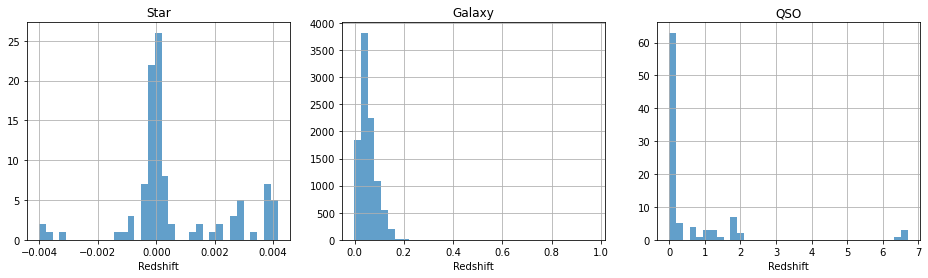

In [13]:
# Create a subplot with three histograms, one for each object class
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

# Iterate through the subplots and corresponding data and labels
for i, (ax, data, label) in enumerate(zip(axes, [SDSS_STAR['redshift'], SDSS_GALAXY['redshift'], SDSS_QSO['redshift']], ['Star', 'Galaxy', 'QSO'])):
    ax.hist(data, bins=35, alpha=0.7, label=label)
    ax.set_xlabel('Redshift')
    ax.set_title(f'{label}')
    ax.grid(True)

**The histograms show the different redshift distribution among different object classes. Galaxies are massive systems of stars, gas, and dust. Their redshifts can vary widely depending on their relative distances from Earth. The redshift distribution for galaxies typically spans a wide range, with some nearby galaxies having low redshifts and distant galaxies exhibiting high redshifts. Individual stars within galaxies have relatively low redshifts compared to galaxies and it is approximately normally distributed around zero. Quasars are extremely distant and luminous sources powered by supermassive black holes. They can exhibit very high redshifts due to their great distances from Earth. Quasars often have some of the highest redshift values observed, making them valuable probes of the early universe.**

### Color-Magnitude Scatter Plot:
**Astronomers use color information to distinguish between different types of celestial objects. In the g-r vs. g color-color scatter plot, the g-r color represents the difference in brightness (magnitude) between the green (g) and red (r) optical filters. This color can help reveal the spectral characteristics of objects, such as the presence of emission lines or absorption features**

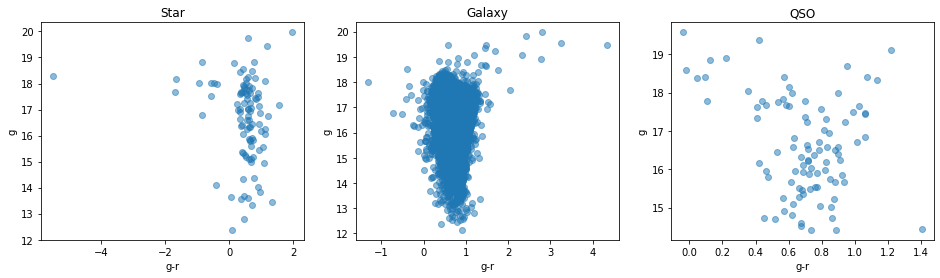

In [14]:
# Create a subplot with three scatter plots, one for each object class
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

# Iterate through the subplots and corresponding data and labels
for i, (ax, data, label) in enumerate(zip(axes, [SDSS_STAR, SDSS_GALAXY, SDSS_QSO], ['Star', 'Galaxy', 'QSO'])):
    ax.scatter(data['g']-data['r'], data['g'], alpha=0.5, label=label)
    ax.set_xlabel('g-r')
    ax.set_ylabel('g')
    ax.set_title(f'{label}')

### 2D Histograms of Color-Magnitude Diagram (CMD):
**To make these highly densed scatter plots more understandable, a color-coded density plot (shown below) can be plotted.**

In [15]:
# Create a 3 set of 2D histogram of (g-r) color vs. g magnitude for each class
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

for i, (ax, data, label) in enumerate(zip(axes, [SDSS_STAR, SDSS_GALAXY, SDSS_QSO], ['Star', 'Galaxy', 'QSO'])):
    # Plot a 2D histogram of (g-r) color vs. g magnitude for the current class
    im = ax.hist2d(data['g']-data['r'], data['g'], bins=40, label=label)
    ax.set_xlabel('g-r')
    ax.set_ylabel('g')
    ax.set_title(f'{label}')
    plt.colorbar(im[3], ax=ax)


**Stars typically have a relatively tight cluster in color space because they emit light across a broad spectrum, and their colors are relatively stable. The scatter plot for galaxies shows a broader and more spread-out distribution in color space compared to stars. Galaxies come in various shapes, sizes, and colors, so their colors can vary significantly.
The scatter plot for quasars (QSOs) shows a distinct population of objects with different colors compared to stars and galaxies.
Quasars are extremely bright and energetic sources in the universe, and they often exhibit unique color properties.**

### Correlation Heatmaps for Different Bands in Photometric System:
**The correlation heatmap between different celestial objects can provide valuable insights into how these objects differ in terms of their photometric properties.**

In [16]:
# Calculate the absolute correlation matrix for selected features within the Star class
STAR_HEATMAP = abs(SDSS_STAR[['u', 'g', 'r', 'i', 'z']].corr()).style.background_gradient(cmap='Greens', vmin=0.6, vmax=1)
STAR_HEATMAP.set_caption("Correlation Matrix for Star")

In [17]:
# Calculate the absolute correlation matrix for selected features within the Galaxy class
GALAXY_HEATMAP = abs(SDSS_GALAXY[['u', 'g', 'r', 'i', 'z']].corr()).style.background_gradient(cmap='Greens', vmin=0.6, vmax=1)
GALAXY_HEATMAP.set_caption("Correlation Matrix for Galaxy")

In [18]:
# Calculate the absolute correlation matrix for selected features within the Qso class
QSO_HEATMAP = abs(SDSS_QSO[['u', 'g', 'r', 'i', 'z']].corr()).style.background_gradient(cmap='Greens', vmin=0.6, vmax=1)
QSO_HEATMAP.set_caption("Correlation Matrix for Qso")

### Thumbnail Cutouts of Celestial Objects:
**The SDSS database also includes millions of spectra and color imaging, and SkyServer provides a service that will produce the color image cutouts of certain dimensions around a specified celestial coordinate (ra vs dec), displayed as a JPG thumbnail. These cutouts provide a visual dimension to the classification process, aiding in verification, and feature extraction, which can improve the accuracy of classification models.**

**The code below iterates through the first 12 objects of each class and calls the corresponding image cutout generator. The scale of the image depends on the Petrosian radius of the object.**

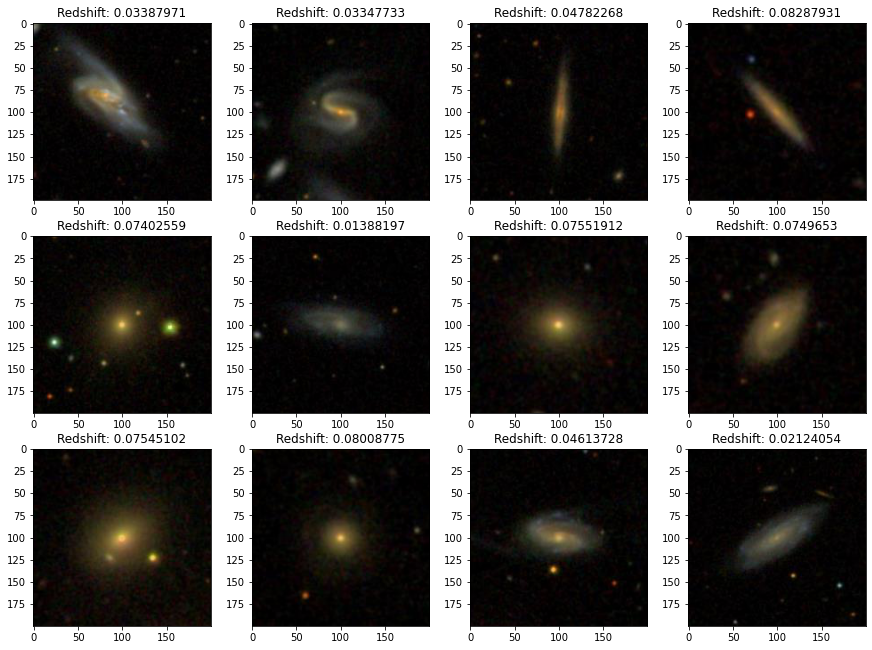

In [92]:
# Create a grid of thumbnail cutouts for galaxies using SkyServer's image cutout service.
# Set the width and height of each thumbnail in pixels
width=200
height=200
pixelsize=0.396

plt.figure(figsize=(15, 15))   
subPlotNum = 1       # Initialize subplot numbering
i = 0
# Iterate through the galaxies in the SDSS_GALAXY DataFrame
for _, gal in SDSS_GALAXY.iterrows():
    i = i + 1
    # Limit the number of displayed thumbnails to 12
    if i<= 12:
        # Calculate the scale for the cutout based on the galaxy's size
        scale=2*gal['petror90_r']/pixelsize/width
        
        # Retrieve the thumbnail cutout image using SkyServer's image cutout service
        img= SciServer.SkyServer.getJpegImgCutout(ra=gal['ra'], dec=gal['dec'], width=width, height=height, scale=scale,dataRelease='DR13')
        plt.subplot(4,4,subPlotNum)
        subPlotNum += 1
        plt.imshow(img)
        plt.title(f'Redshift: {gal["redshift"]}')

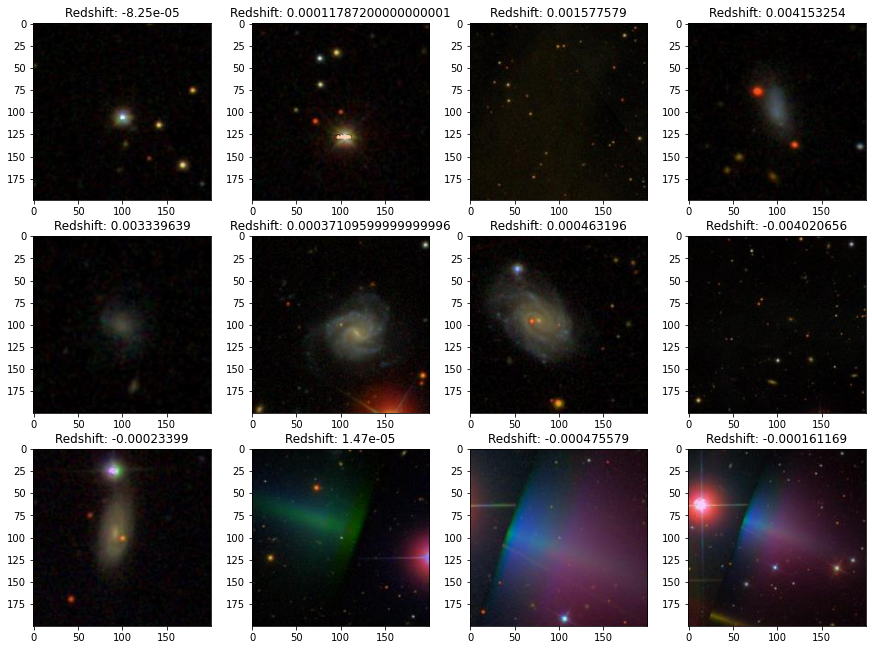

In [93]:
# Create a grid of thumbnail cutouts for stars using SkyServer's image cutout service.
width=200
height=200
pixelsize=0.396
plt.figure(figsize=(15, 15))
subPlotNum = 1

i = 0
nStars = len(SDSS_STAR)
for _,star in SDSS_STAR.iterrows():
    i = i + 1
    if i<= 12:
        # Calculate the scale for the cutout based on the galaxy's size
        scale=2*star['petror90_r']/pixelsize/width
        
        # Retrieve the thumbnail cutout image using SkyServer's image cutout service
        img= SciServer.SkyServer.getJpegImgCutout(ra=star['ra'], dec=star['dec'], width=width, height=height, scale=scale,dataRelease='DR13')
        plt.subplot(4,4,subPlotNum)
        subPlotNum += 1
        plt.imshow(img)
        plt.title(f'Redshift: {star["redshift"]}')

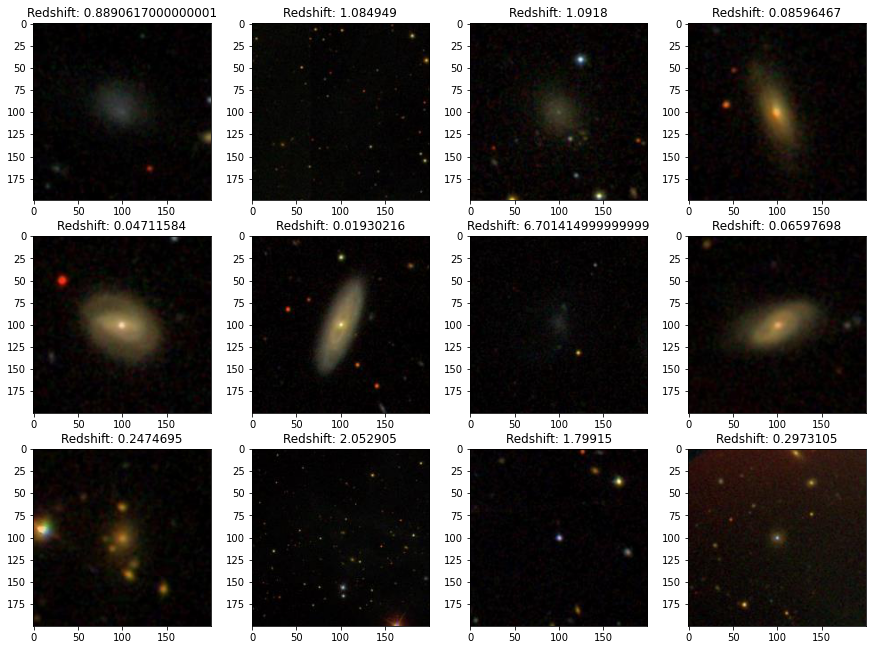

In [94]:
# Create a grid of thumbnail cutouts for Quasars using SkyServer's image cutout service.
width=200
height=200
pixelsize=0.396
plt.figure(figsize=(15, 15))
subPlotNum = 1

i = 0
for _,QSO in SDSS_QSO.iterrows():
    i = i + 1
    if i<= 12:
        # Calculate the scale for the cutout based on the galaxy's size
        scale=2*QSO['petror90_r']/pixelsize/width
        
        # Retrieve the thumbnail cutout image using SkyServer's image cutout service
        img= SciServer.SkyServer.getJpegImgCutout(ra=QSO['ra'], dec=QSO['dec'], width=width, height=height, scale=scale,dataRelease='DR13')
        plt.subplot(4,4,subPlotNum)
        subPlotNum += 1
        plt.imshow(img)
        plt.title(f'Redshift: {QSO["redshift"]}')

> Note that galaxies and quasars are stronger radiants (could be seen fro the redshift histograms) and thus can be captured from the further celestial coordinates and thus they might be pretty close to each other at some locations resulting in overlap in some thumbnail cutouts.

# Supervised Learning - Celestial Classification
**Three different modelsis used to train the dataset. To ensure the robustness and efficiency of these models, feature scaling is employed. Scaling normalizes all feature values, preventing distortion caused by exceptionally high data points, which not only enhances the convergence speed of various algorithms, but also contributes to their overall performance. Following this preprocessing step, the data undergoes a division into distinct training and testing sets, ready to be harnessed in the training and evaluation of the classifiers.**
> In this section the plot_learning_curves function is used in for assessing and visualizing the learning behavior of different classifiers, aiding in the selection and fine-tuning of the models.

In [45]:
def plot_learning_curves(classifiers, classifier_names, X, y, cv=10, figsize=(12, 5)):
    """
    Plot learning curves for multiple classifiers.
    
    Parameters:
        classifiers: List of classifier objects.
        classifier_names: List of classifier names for labeling the plots.
        X: Training data.
        y: Target values.
        cv (optional): Number of cross-validation folds.
        figsize (optional): Size of each figure
    """
    plt.figure(figsize=figsize)
    
    for clf, clf_name in zip(classifiers, classifier_names):
        
        # Compute learning curves using the learning_curve function
        train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=cv)
        # Calculate the mean and standard deviation of training and testing scores
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        plt.subplot(1, len(classifiers), classifier_names.index(clf_name) + 1)
        plt.title(f"{clf_name} - Learning Curve")
        plt.xlabel("Training Examples")
        plt.ylabel("Accuracy")
        plt.grid()
        
        # Fill the area around the mean training and testing scores with a shaded region
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training Score")
        plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-Validation Score")
        plt.legend(loc="best")
    
    plt.tight_layout()
    plt.show()


### 1. K-Nearest Neighbors (KNN):

In [126]:
scaler = StandardScaler()           # Create a StandardScaler object to standardize the features
X = scaler.fit_transform(SDSS.drop('class', axis=1))
Y = SDSS['class']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)   # Split the data into training and testing sets

#### Hyperparameter tuning: 
Evaluating the model performance for a range of "k" values and visualizing the results to determine the optimal "k" value for the given dataset. Results indicate that the optimal k value for the model is k=6 whre it has the highest accuracy for the testing set.

In [62]:
# Experiment with K 
size = 50                      # Define the maximum number of values for K
K = np.array(range(1,250))     # Create an array of K values ranging from 1 to 249
numElems = len(K) if len(K) < size else size
# Create an index array with evenly spaced values from 0 to len(K)-1
idx = np.round(np.linspace(0, len(K) - 1, numElems)).astype(int)
K = [K[i] for i in idx]

clfs = []
for k in K:
    # Create a KNN classifier with the current K value and train it on the dataset
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, Y_train)
    clfs.append(clf)

# Calculate and store the training and testing scores for each classifier
train_scores = [clf.score(X_train, Y_train) for clf in clfs]
test_scores = [clf.score(X_test, Y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("k")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs k for training and testing sets")
ax.plot(K, train_scores, marker="", label="train", drawstyle="steps-post")
ax.plot(K, test_scores, marker="", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# Find and print the K value that maximizes the test scores
print(f"K: {K[np.argmax(test_scores, axis=0)]}" )
print(test_scores)

K: 6
[0.9742424242424242, 0.9866666666666667, 0.9863636363636363, 0.9863636363636363, 0.9860606060606061, 0.9863636363636363, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.9848484848484849, 0.984848484848

- Use the plot_learning_curve function to compare and visualize the effect of k value (optimal vs a randomely large value) on the learning behavior of the model. The KNN model with k=6 (optimal) exhibits better performance in terms of generalization to unseen data, as evidenced by the increasing cross-validation score with more training examples. The KNN model with k=245, while performing well on the training data, doesn't generalize as effectively to new data, as indicated by the constant cross-validation score.

In [120]:
# Compare the performance of two K-Nearest Neighbors (KNN) classifiers with different values of K
# Create KNN classifiers with specific values of K
knn1 = KNeighborsClassifier(n_neighbors=245)
knn2 = KNeighborsClassifier(n_neighbors=6)

classifiers = [knn1, knn2]
classifier_names = ["KNN (k=245)", "KNN (k=6)"]
# Plot learning curves for the two classifiers
plot_learning_curves(classifiers, classifier_names, np.concatenate((X_train, X_test), axis=0), np.concatenate((Y_train, Y_test), axis=0), cv=10)


In [127]:
# Use the optimal k value for KNN classifier, fit and predict
knn2.fit(X_train, Y_train)
Y_pred = knn2.predict(X_test)

In [129]:
# Evaluate the model
accuracy_KNN = accuracy_score(Y_test, Y_pred)*100

print("K Nearest Neighbors Classifier's Prediction Accuracy (k=6):", accuracy)
# Generate a classification report, including precision, recall, and F1-score
precision_score_KNN = classification_report(Y_test, Y_pred, output_dict=True)['weighted avg']['precision']
recall_score_KNN = classification_report(Y_test, Y_pred, output_dict=True)['weighted avg']['recall']
f1_score_KNN = classification_report(Y_test, Y_pred, output_dict=True)['weighted avg']['f1-score']
print(classification_report(Y_test, Y_pred))

K Nearest Neighbors Classifier's Prediction Accuracy (k=6): 97.57575757575758
              precision    recall  f1-score   support

      GALAXY       0.98      1.00      0.99      3233
         QSO       1.00      0.29      0.45        31
        STAR       0.75      0.08      0.15        36

    accuracy                           0.98      3300
   macro avg       0.91      0.46      0.53      3300
weighted avg       0.98      0.98      0.98      3300



> The model performs very well in predicting the 'GALAXY' class with high precision and recall. However, it struggles to predict the 'QSO' and 'STAR' classes, particularly in terms of recall. The weighted average F1-score of approximately 0.98 indicates strong overall model performance.

In [130]:
# Perform cross validation
scores_KNN = cross_val_score(knn2, X_train, Y_train, cv=5)*100

print("K-Nearest Neighbors Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("std of Accuracy:", scores.std())

K-Nearest Neighbors Cross-Validation Scores: [98.88059701 98.95522388 98.95522388 98.65671642 98.73134328]
Mean Accuracy: 98.83582089552239
std of Accuracy: 0.1212543045468035


### 2. Random Forest Classifier:

In [131]:
scaler = StandardScaler()
X = scaler.fit_transform(SDSS.drop('class', axis=1))
Y = SDSS['class']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33) # Split the data into training and testing sets

#### Grid Search with Cross-Validation:
To systematically explore a range of hyperparameter values (n_estimators and max_depth) for the random forest algorithm and determine the combination of hyperparameters that yields the best performance on a given dataset. It helps optimize the model's hyperparameters to improve its predictive accuracy.

In [126]:
# Define a grid of hyperparameters for Random Forest Classifier
param_grid = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30, 40]
}

rfc = RandomForestClassifier()

# Create the GridSearchCV object and fit it on the data
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
print("Best Parameters: ", grid_search.best_params_)

# Get the best estimator (model) and evaluate it
best_rfc = grid_search.best_estimator_
test_accuracy = best_rfc.score(X_test, Y_test)
print("Test Accuracy with Best Model: ", test_accuracy)

Best Parameters:  {'max_depth': 40, 'n_estimators': 50}
Test Accuracy with Best Model:  0.9854545454545455


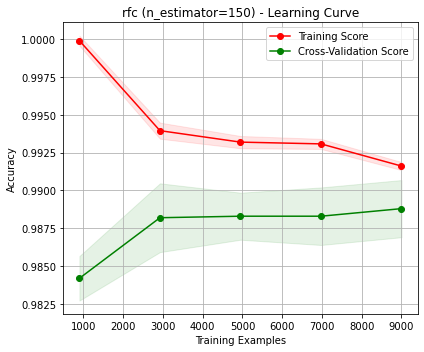

In [132]:
# Visualise the learning curve with optimal hyperparameters
rfc1 = RandomForestClassifier(n_estimators=150, max_depth=10)

classifiers = [rfc1]
classifier_names = ["rfc (n_estimator=150)"]
plot_learning_curves(classifiers, classifier_names, np.concatenate((X_train, X_test), axis=0), np.concatenate((Y_train, Y_test), axis=0), cv=10, figsize=(6, 5))

In [132]:
# Create a Random Forest classifier using optimal hyperparameters, train and predict
rfc = RandomForestClassifier(n_estimators=150, max_depth=10)
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)

In [133]:
# Evaluate the model
accuracy_RFC = accuracy_score(Y_test, Y_pred)*100
print("Random Forest Classifier's Prediction Accuracy:", accuracy)

precision_score_RFC = classification_report(Y_test, Y_pred, output_dict=True)['weighted avg']['precision']
recall_score_RFC = classification_report(Y_test, Y_pred, output_dict=True)['weighted avg']['recall']
f1_score_RFC = classification_report(Y_test, Y_pred, output_dict=True)['weighted avg']['f1-score']
print(classification_report(Y_test, Y_pred))

Random Forest Classifier's Prediction Accuracy: 97.57575757575758
              precision    recall  f1-score   support

      GALAXY       0.99      1.00      1.00      3242
         QSO       1.00      0.28      0.44        25
        STAR       0.89      0.76      0.82        33

    accuracy                           0.99      3300
   macro avg       0.96      0.68      0.75      3300
weighted avg       0.99      0.99      0.99      3300



> The model performs great in predicting the 'GALAXY' class with high precision and recall. However, it struggles to predict the 'QSO' class, particularly in terms of recall. The 'STAR' class has reasonably good performance. The weighted average F1-score of approximately 0.98 indicates strong overall model performance, but the model's performance varies across different classes.

In [134]:
# Perform cross validation
scores_RFC = cross_val_score(rfc, X_train, Y_train, cv=5)*100

print("Random Forest Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("std of Accuracy:", scores.std())

Random Forest Cross-Validation Scores: [98.88059701 98.95522388 98.95522388 98.65671642 98.73134328]
Mean Accuracy: 98.83582089552239
std of Accuracy: 0.1212543045468035


In [76]:
# feature Importance Analysis
feature_importance = rfc.feature_importances_        # Calculate feature importance using the Random Forest Classifier

# Create its DataFrame
importance = pd.DataFrame({
    'Feature': SDSS.drop('class', axis=1).columns,
    'Importance': feature_importance
})
# Sort the features by importance in descending order
importance = importance.sort_values(by='Importance', ascending=False)
importance = importance.set_index('Feature')
importance

Importance
Feature               
redshift      0.513886
z             0.059796
r             0.058104
u             0.056299
i             0.042189
fiberid       0.040194
petror90_r    0.040099
g             0.039536
ra            0.034593
specobjid     0.033969
mjd           0.028371
plate         0.027271
dec           0.025695

### 3. Neural Networks (MLP Classifier):
Multi-layer Perceptron (MLP) classifier is a feedforward artificial neural network that consists of multiple layers of interconnected neurons or nodes. Each neuron in an MLP is connected to every neuron in the adjacent layers, making it a densely connected or fully connected neural network.

In [143]:
scaler = MinMaxScaler()
X = scaler.fit_transform(SDSS.drop('class', axis=1))
Y = SDSS['class']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)   # Split the data into training and testing sets

#### Hyperparameter Tuning Process Using Grid Search with Cross-Validation:
To finf the optimal combination of alpha and hidden_layer_size values

In [79]:
# Define a parameter grid with different values for alpha and hidden_layer_sizes
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)]
}

clf = MLPClassifier(activation='logistic', max_iter=1000)

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, Y_train)
print("Best Parameters: ", grid_search.best_params_)

# Get the best model (estimator) with the optimal hyperparameters
best_alpha = grid_search.best_params_['alpha']
best_hidden_layers = grid_search.best_params_['hidden_layer_sizes']
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, Y_test)    # Evaluate the model
print("Test Accuracy with Best Model: ", test_accuracy)

Best Parameters:  {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
Test Accuracy with Best Model:  0.9775757575757575


- Evaluating the model performance for a range of "hidden layers" values and visualizing the results to determine the match with the grid serach. Results from thse two analysis indicate that the optimal hyperparameter values for alpha and hidden layers are 0.0001 and (133,), respectively.

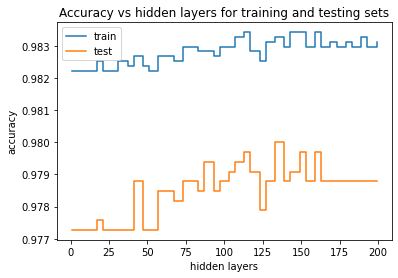

Layers: 133
[0.9772727272727273, 0.9772727272727273, 0.9772727272727273, 0.9775757575757575, 0.9772727272727273, 0.9772727272727273, 0.9772727272727273, 0.9772727272727273, 0.9787878787878788, 0.9772727272727273, 0.9772727272727273, 0.9784848484848485, 0.9784848484848485, 0.9781818181818182, 0.9787878787878788, 0.9787878787878788, 0.9784848484848485, 0.9793939393939394, 0.9784848484848485, 0.9787878787878788, 0.9790909090909091, 0.9793939393939394, 0.9796969696969697, 0.9790909090909091, 0.9778787878787879, 0.9787878787878788, 0.98, 0.9787878787878788, 0.9790909090909091, 0.9796969696969697, 0.9787878787878788, 0.9796969696969697, 0.9787878787878788, 0.9787878787878788, 0.9787878787878788, 0.9787878787878788, 0.9787878787878788, 0.9787878787878788, 0.9787878787878788, 0.9787878787878788]


In [24]:
size = 40                          # Define the maximum number of hidden layers to consider
layers = np.array(range(1,201,2))  # Create an array as potential hidden layer sizes
numElems = len(layers) if len(layers) < size else size
idx = np.round(np.linspace(0, len(layers) - 1, numElems)).astype(int)   # Calculate the indices of selected elements
layers = [layers[i] for i in idx]    # Select a subset of hidden layer sizes based on the calculated indices


log_clfs = []
for i in layers:
    clf1 = MLPClassifier(activation='logistic', hidden_layer_sizes=(i,), max_iter=1000)
    clf1.fit(X_train, Y_train)
    log_clfs.append(clf1)

# Calculate the training and testing accuracy scores for each model
log_train_scores = [clf.score(X_train, Y_train) for clf in log_clfs]
log_test_scores = [clf.score(X_test, Y_test) for clf in log_clfs]

fig, ax = plt.subplots()
ax.set_xlabel("hidden layers")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs hidden layers for training and testing sets")
ax.plot(layers, log_train_scores, marker="", label="train", drawstyle="steps-post")
ax.plot(layers, log_test_scores, marker="", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

print(f"Layers: {layers[np.argmax(log_test_scores, axis=0)]}" )
print(log_test_scores)

- Use the plot_learning_curve function to compare and visualize the effect of hidden layers and alpha values (optimal vs a randomely small value) on the learning behavior of the model. The MLP model with alpha=0.0001 and layers=133 (optimal) exhibits better performance in terms of generalization to unseen data, as evidenced by the increasing cross-validation score with more training examples. The MLP model with alpha=0.001 and layers=15, while performing well on the training data, doesn't generalize as effectively to new data, as indicated by the constant cross-validation score.

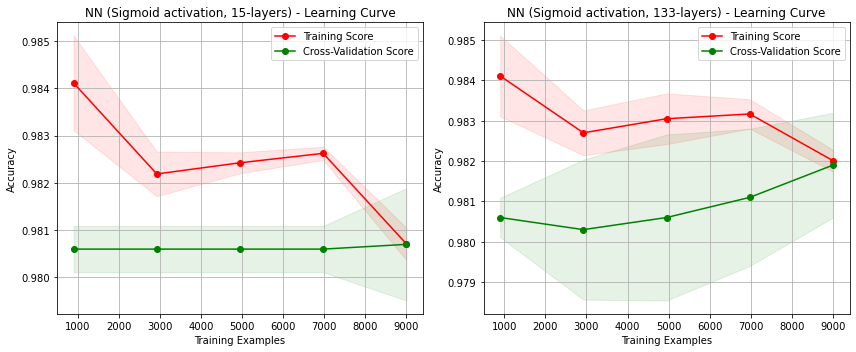

In [81]:
# Neural Network (MLP) Learning Curves for Different Architectures
nn1 = MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(15,), max_iter=1000)
nn2 = MLPClassifier(activation='logistic', alpha=0.0001, hidden_layer_sizes=(133,), max_iter=1000)

classifiers = [nn1, nn2]
classifier_names = ["NN (Sigmoid activation, 15-layers)", "NN (Sigmoid activation, 133-layers)"]
# Call the 'plot_learning_curves' function to visualize learning curves
plot_learning_curves(classifiers, classifier_names, np.concatenate((X_train, X_test), axis=0), np.concatenate((Y_train, Y_test), axis=0), cv=10)

In [144]:
# create a MLP classifier using optimal hyperparameters, train and predict
clf = MLPClassifier(activation='logistic', alpha=0.0001, hidden_layer_sizes=(133,), max_iter=1000)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

In [146]:
# evaluate the model
accuracy_MLP = accuracy_score(Y_test, Y_pred)*100
print("Neural Network MLP Classifier's Prediction Accuracy:", accuracy)

precision_score_MLP = classification_report(Y_test, Y_pred, output_dict=True)['weighted avg']['precision']
recall_score_MLP = classification_report(Y_test, Y_pred, output_dict=True)['weighted avg']['recall']
f1_score_MLP = classification_report(Y_test, Y_pred, output_dict=True)['weighted avg']['f1-score']
print(classification_report(Y_test, Y_pred))

Neural Network MLP Classifier's Prediction Accuracy: 97.57575757575758
              precision    recall  f1-score   support

      GALAXY       0.99      1.00      0.99      3242
         QSO       1.00      0.23      0.37        31
        STAR       0.33      0.11      0.17        27

    accuracy                           0.98      3300
   macro avg       0.77      0.45      0.51      3300
weighted avg       0.98      0.98      0.98      3300



> The model achieves high accuracy primarily because it is effective at classifying 'GALAXY' objects but performs poorly on 'QSO' and 'STAR' objects. It has low recall, precision, and F1-scores for these minority classes, which suggests a class imbalance issue, lack of enough data in these classes compared to the 'GALAXY' class.

In [147]:
# perform cross validation
scores_MLP = cross_val_score(rfc, X_train, Y_train, cv=5)*100

print("Neural Network MLP Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("std of Accuracy:", scores.std())

Neural Network MLP Cross-Validation Scores: [98.88059701 98.95522388 98.95522388 98.65671642 98.73134328]
Mean Accuracy: 98.83582089552239
std of Accuracy: 0.1212543045468035


# Comparing Performance Metrics of Different Classifiers:

In [171]:
Evaluation = pd.DataFrame({
    'Classifiers': ['KNN', 'RFC', 'MLP'],
    'Accuracy Mean': [scores_KNN.mean(), scores_RFC.mean(), scores_MLP.mean()],
    'Accuracy Std': [scores_KNN.std(), scores_RFC.std(), scores_MLP.std()],
    'Precision': [precision_score_KNN, precision_score_RFC, precision_score_MLP],
    'Recall': [recall_score_KNN, recall_score_RFC, recall_score_MLP],
    'F1 Score': [f1_score_KNN, f1_score_RFC, f1_score_MLP],
})

# Rename the index rows
Evaluation.set_index('Classifiers', inplace=True)
Evaluation

Accuracy Mean  Accuracy Std  Precision    Recall  F1 Score
Classifiers                                                            
KNN              98.283582      0.141595   0.980880  0.983030  0.977146
RFC              98.731343      0.141595   0.991105  0.991212  0.989557
MLP              98.791045      0.109679   0.980186  0.983636  0.979120

> Overall, all three classifiers demonstrate strong performance, but RFC and MLP stand out with very high accuracy, precision, recall, and F1 scores. RFC appears to have a slightly better balance between precision and recall, resulting in a higher F1 score compared to MLP. MLP, on the other hand, shows competitive performance with slightly higher accuracy and recall. The choice between RFC and MLP may depend on other factors such as model interpretability, computational resources, and ease of training. Further analysis and consideration of these factors could help in making a decision between the two classifiers.

# References:

https://www.sdss.org/   
https://github.com/brittlundgren/SDSS-EPO/blob/master/SciServer_notebooks/Week3_Queries_Visualization_clear.ipynb  
https://www.kaggle.com/code/lucidlenn/data-analysis-and-classification-using-xgboost/notebook  
https://www.kaggle.com/code/cammahana/supervised-learning-sdss#k-Neigherest-Neighbors  
